In [1]:
# Import the necessary libraries
import sys
import os
PROJ_DIR = os.path.realpath(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.join(PROJ_DIR,'src'))
import xai_faithfulness_experiments_lib_edits as fl
import numpy as np
from typing import Optional
from tqdm import tqdm
import captum_generator as cg
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

ACTIVATION_THRESHOLD = 0.9
Z_SCORE_THRESHOLD = 4
DESIRED_EXPLANATIONS = 1000

DATASET = 'imagenet'
MODEL_NAME = 'resnet18'

# Load dataset
if DATASET == '20newsgroups-truncated':
    DATASET_PATH = os.path.join(PROJ_DIR,'assets', 'data', f'{DATASET}.npz')
    # Load dataset
    file_data = np.load(DATASET_PATH)
    x_train = torch.from_numpy(file_data['x_train']).float().to(device)
    y_train = torch.from_numpy(file_data['y_train']).to(device)
    test_loader = [(x_train, y_train)]
else:
    #torch.manual_seed(0)
    test_loader = fl.get_image_test_loader(DATASET, 1000, PROJ_DIR, shuffle = True)


# Load model
if DATASET == 'imagenet':
    network = fl.load_pretrained_imagenet_model(arch = MODEL_NAME)
elif DATASET == 'mnist':
    MODEL_PATH = os.path.join(PROJ_DIR,'assets', 'models', f'{DATASET}-{MODEL_NAME}-mlp.pth')
    network = fl.load_pretrained_mnist_model(MODEL_PATH)
elif DATASET == 'cifar':
    MODEL_PATH = os.path.join(PROJ_DIR,'assets', 'models', f'{DATASET}-{MODEL_NAME}-mlp.pth')
    network = fl.load_pretrained_cifar_model(MODEL_PATH)
elif DATASET == '20newsgroups-truncated':
    MODEL_PATH = os.path.join(PROJ_DIR,'assets', 'models', f'{DATASET}{MODEL_NAME}-mlp.pth')
    network = fl.load_pretrained_mlp_large_model(MODEL_PATH, x_train.shape[1], 20, [1000, 1000, 800, 500])
else:
    raise Exception(f'ERROR: Unknown dataset {DATASET}')

Using cuda:0
Loading Resnet18


In [2]:
import pickle

FILENAME = f'{DATASET}_{MODEL_NAME}_exceptionals.pkl'

if os.path.isfile(os.path.join(PROJ_DIR, 'results', FILENAME)):
    with open(os.path.join(PROJ_DIR, 'results', FILENAME), 'rb') as fIn:
        results = pickle.load(fIn)
else:
    # The mean is zero because this dataset is standardized
    num_vars = None
    masking_values = None

    with torch.no_grad():
        valid_elements = []

        for batch_idx, (x_train, y_train) in enumerate(test_loader):
            print(f'Loaded batch  {batch_idx}')
            if masking_values is None:
                masking_values = torch.from_numpy(np.zeros(x_train.shape[1:])).float().to(device)
                num_vars  = 1
                for d in x_train.shape[1:]:
                    num_vars *= d
                num_samples = min(fl.NUM_SAMPLES, num_vars)
                input_shape = x_train.shape[1:]
            # Find elements from the batch that activate the network enough
            outputs = network(x_train.to(device))
            activated_indices = (outputs[torch.arange(x_train.shape[0]), y_train]>ACTIVATION_THRESHOLD).nonzero().flatten()

            for i, sample_index in enumerate(activated_indices):
                if (i+1) % 10 == 0:
                    print(f' Exploring activating sample {i+1}/{activated_indices.size()[0]}')
                row = x_train[sample_index.item()].to(device)
                label = y_train[sample_index.item()].to(device)
            
                #Compute 100 random rankings to compute the average q
                qmeans = []
                for _ in range(100):
                    measures = fl.get_measures_for_ranking(row, fl._get_random_ranking_row(row.shape), label, network, with_inverse=False, with_random=False, masking_values=masking_values)
                    qmeans.append(measures['mean'])
                qmean_mean = np.mean(qmeans)
                qmean_std = np.std(qmeans)
        
                #Grab captum generated explanations and check their z-index
                captum_rankings = torch.tensor(cg.generate_rankings(row, label, network)).to(device)
                for method_index, ranking in enumerate(captum_rankings):
                    measures = fl.get_measures_for_ranking(row, ranking, label, network, with_inverse=False, with_random=False, masking_values=masking_values)
                    zscore = (measures['mean'] -  qmean_mean) /  qmean_std
                    if zscore > 4:
                        valid_elements.append({'row': row,\
                                            'ranking': ranking,\
                                            'label': label,\
                                            'qmean_mean': qmean_mean,\
                                            'qmean_std': qmean_std,\
                                            'method': method_index
                                            })
                        print(f'{len(valid_elements)}/{DESIRED_EXPLANATIONS}')
                        if len(valid_elements) >= DESIRED_EXPLANATIONS:
                            break
                if len(valid_elements) >= DESIRED_EXPLANATIONS:
                    break

    results = []
    for v in valid_elements:
        row  = v['row']
        ranking = v['ranking']
        label = v['label']
        measures = fl.get_measures_for_ranking(row, ranking, label, network, with_inverse=True, with_random=True, masking_values=masking_values)
        v['qmean'] = measures['mean']
        v['qinv'] = measures['mean_inv']
        v['qbas'] = measures['mean_bas']
        results.append(v)
    with open(os.path.join(PROJ_DIR, 'results', FILENAME), 'wb') as fOut:
        pickle.dump(results, fOut)
                

0.6562854825628547


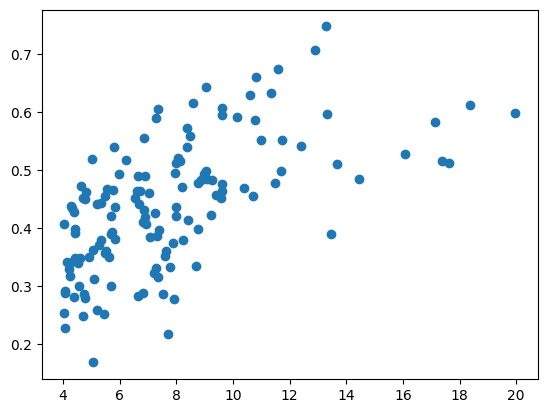

0.8039788178044939


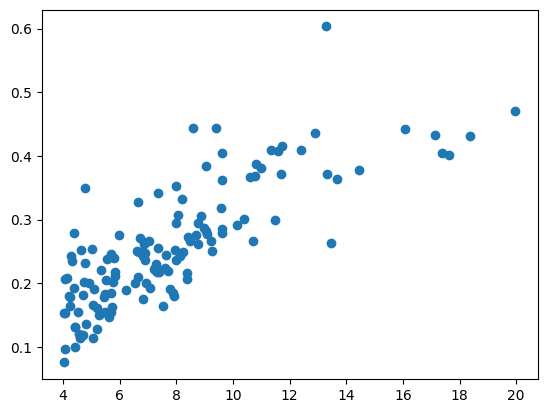

In [12]:
filtered = [x for x in results if x['method']==0 and x['qmean']>0.5]
#filtered = results

from scipy.stats import spearmanr
from matplotlib import pyplot as plt
zindices = list(map(lambda x: (x['qmean']-x['qmean_mean'])/x['qmean_std'], filtered))
#zindices = list(map(lambda x: x['qmean'], filtered))
qinv = list(map(lambda x: x['qinv'], filtered))
qbas = list(map(lambda x: x['qbas'], filtered))

print(spearmanr(zindices, qinv).statistic)
plt.scatter(zindices,  qinv)
plt.show()
print(spearmanr(zindices, qbas).statistic)
plt.scatter(zindices,  qbas)
plt.show()

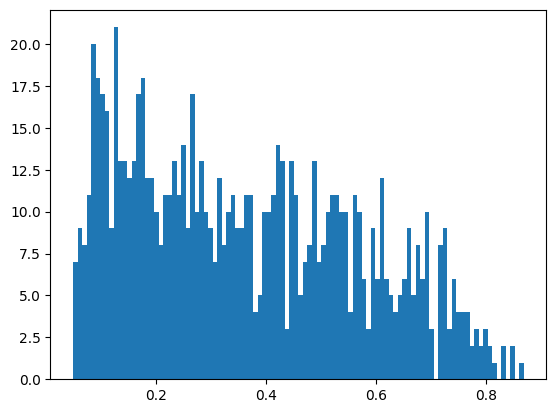

In [19]:
plt.hist(zindices, bins=100)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(193)
0.7966678
0.23721758
0.038174912
tensor(0.9385, device='cuda:0', grad_fn=<MaxBackward1>)


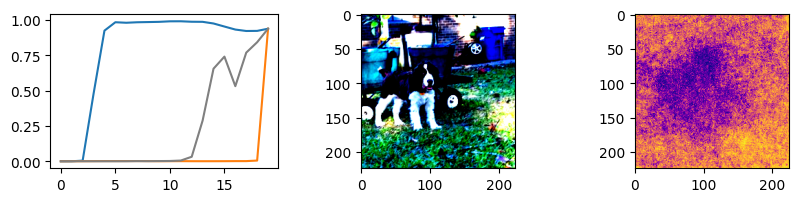

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(73)
0.8124033
0.5515992
0.038202956
tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)


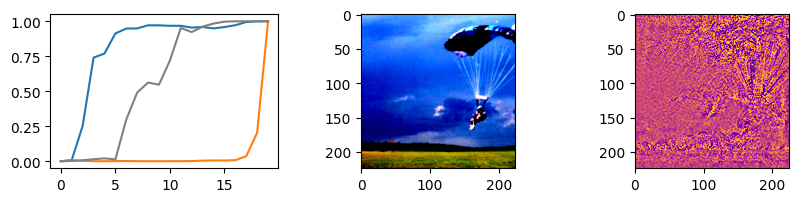

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(35)
0.7894591
0.4332154
0.035267785
tensor(0.9997, device='cuda:0', grad_fn=<MaxBackward1>)


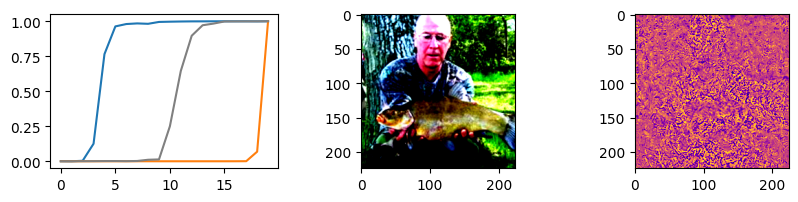

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(92)
0.7898346
0.46592072
0.049330954
tensor(0.9998, device='cuda:0', grad_fn=<MaxBackward1>)


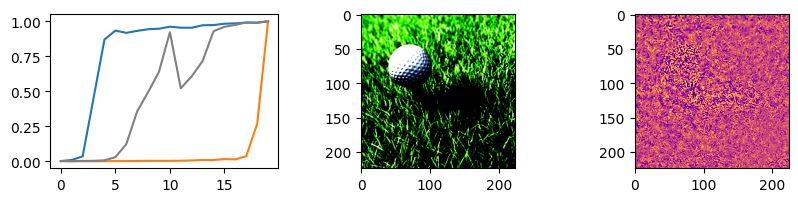

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(16)
0.7689253
0.48669967
0.043762654
tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)


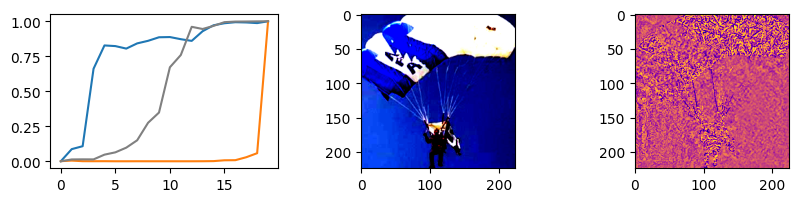

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(154)
0.76725733
0.36804336
0.03338716
tensor(0.9624, device='cuda:0', grad_fn=<MaxBackward1>)


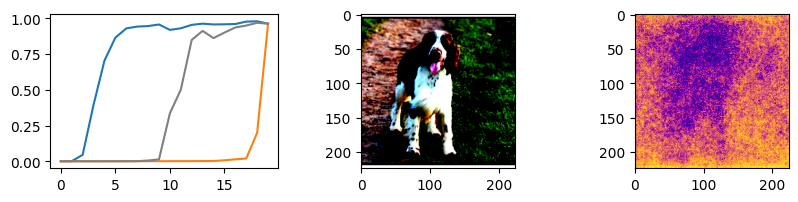

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(201)
0.751869
0.48443362
0.033073347
tensor(0.9991, device='cuda:0', grad_fn=<MaxBackward1>)


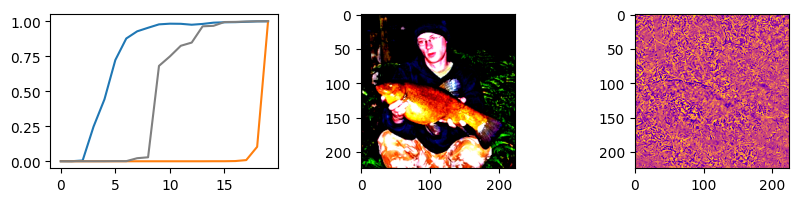

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(41)
0.72588587
0.28284302
0.041584883
tensor(0.9992, device='cuda:0', grad_fn=<MaxBackward1>)


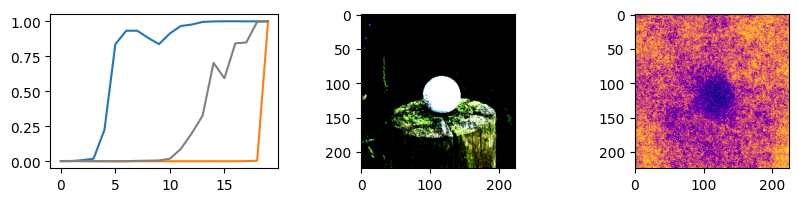

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(23)
0.7438666
0.3364465
0.041261274
tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)


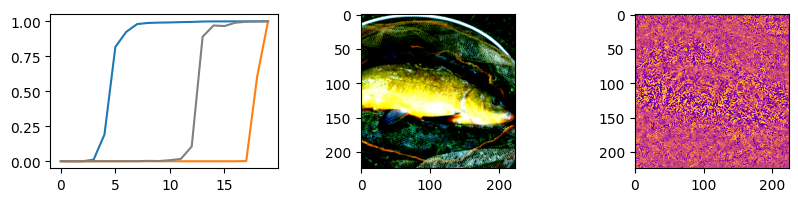

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(127)
0.72492176
0.49100712
0.03748283
tensor(0.9992, device='cuda:0', grad_fn=<MaxBackward1>)


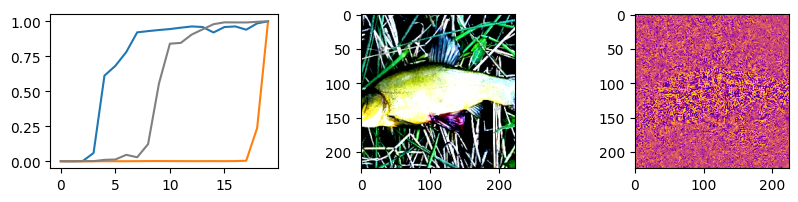

In [57]:
NUM_ELEMS = 10

indices = torch.tensor(qinv).topk(NUM_ELEMS, largest=True).indices

for i in indices:
    print(i)
    v = filtered[i]
    row  = v['row']
    ranking = v['ranking']
    label = v['label']
    masking_values = torch.from_numpy(np.zeros(row.shape)).float().to(device)
    measures = fl.get_measures_for_ranking(row, ranking, label, network, with_inverse=True, with_random=True, masking_values=masking_values)
    
    print(measures['mean'])
    print(v['qmean_mean'])
    print(v['qmean_std'])
    print(network(row.unsqueeze(0)).max())
    fig, axs = plt.subplots(1, 3, figsize=(10, 2))
    axs[0].plot(measures['output_curve'])
    axs[0].plot(measures['output_curve_inv'])
    axs[0].plot(measures['output_curve_bas'], color='gray')
    axs[1].imshow(np.moveaxis(v['row'].detach().cpu().numpy(), 0, -1))
    axs[2].imshow(v['ranking'].sum(axis=0).detach().cpu().numpy(), cmap='plasma')
    plt.show()

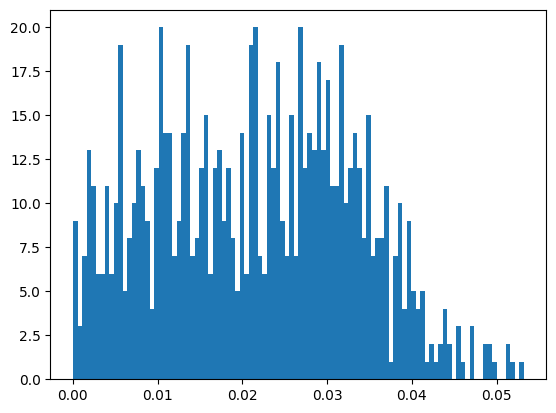

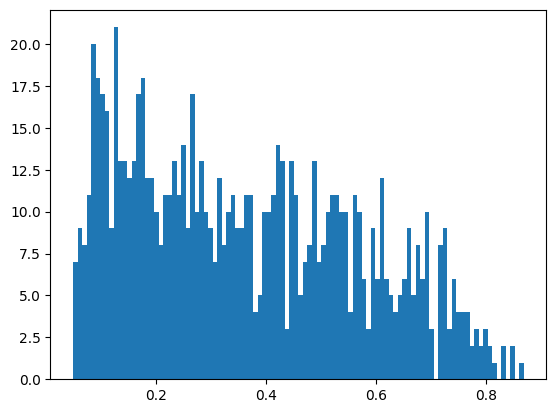

In [26]:
plt.hist(list(map(lambda x: x['qmean_std'], results)),bins=100)
plt.show()
plt.hist(list(map(lambda x: x['qmean'], results)),bins=100)
plt.show()